# Forcasting precipitations in Morocco communes 2000-2018 data

## Preparing Data

In [1]:
import psycopg2
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = psycopg2.connect('dbname=wm-22-precip-DB user=postgres password=postgres host=localhost')
cur = conn.cursor()

In [4]:
sql_colnms = """SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = N'prepMa'"""

sql_prepMa = '''SELECT * FROM "prepMa"'''

In [5]:
d = pd.read_sql_query(sql_prepMa,conn)
conn.close()

/home/ayoub/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
mapIdMap = dict(zip(d['name'], d['fid']))

In [7]:
df = d.copy()

In [8]:
df.set_index(['id'])
df.drop(columns=['objectid', 'geom', 'fid', 'name', 'id'], inplace=True)
df_ = df.T
df_.index = pd.to_datetime([f'{i[:7]}' for i in df_.index])
df_.sort_index(inplace=True)
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541
2000-01-01,5.139662,5.185174,12.736306,7.222152,8.277916,10.003084,3.690965,4.015777,3.724388,3.973375,...,80.943738,53.279457,58.557885,42.157584,37.573582,37.573582,37.573582,37.573582,39.338377,40.711483
2000-02-01,2.320398,2.510182,7.483267,3.029178,3.857246,4.342615,2.725529,1.264757,2.803877,1.386363,...,1.866421,1.128736,1.365121,0.964586,0.890602,0.890602,0.890602,0.890602,0.922023,1.099783
2000-03-01,1.026504,0.911228,4.644095,0.968059,2.144454,1.894135,1.811047,1.650475,1.805033,0.908379,...,28.641492,19.283579,24.587897,5.983350,6.307444,6.307444,6.307444,6.307444,6.350355,3.502182
2000-04-01,0.994122,0.929610,3.478880,0.909780,1.619741,1.273522,1.302462,0.677425,1.902222,0.860408,...,95.467146,113.049248,108.450883,72.007683,69.569077,69.569077,69.569077,69.569077,70.999270,56.441982
2000-05-01,0.000000,0.000000,0.749234,0.000000,0.010291,0.000000,0.000000,0.974401,0.000000,0.984279,...,46.760845,48.911781,53.525117,21.432269,22.532732,22.532732,22.532732,22.532732,21.880218,18.199196


In [9]:
df_.to_csv('precipCommunesTS.csv')

Link to this ~cleaned dataset : [🔗](https://drive.google.com/file/d/1E34cl3U9q_U5NC96G3l8uGWorlRwqfTQ/view?usp=sharing)

## EDA precipitation of Khouribga commune

In [10]:
mapIdMap['Khouribga']

332

In [11]:
df_kh = pd.DataFrame(df_[332])

In [12]:
df_kh.rename(columns={332: "precipKhouribga"}, inplace=True)

In [13]:
df_kh.head()

,precipKhouribga
2000-01-01,13.872842
2000-02-01,7.474373
2000-03-01,2.075285
2000-04-01,38.477597
2000-05-01,7.025321


In [14]:
df_kh.drop('2019-12-01', inplace=True) #deleted one entry of 2019

In [15]:
df_kh.tail()

,precipKhouribga
2018-08-01,6.111350
2018-09-01,4.688000
2018-10-01,34.422764
2018-11-01,43.916373
2018-12-01,13.955878


In [16]:
sns.set()

### Plotting the variation of precipitation in Khouribga commune over the years

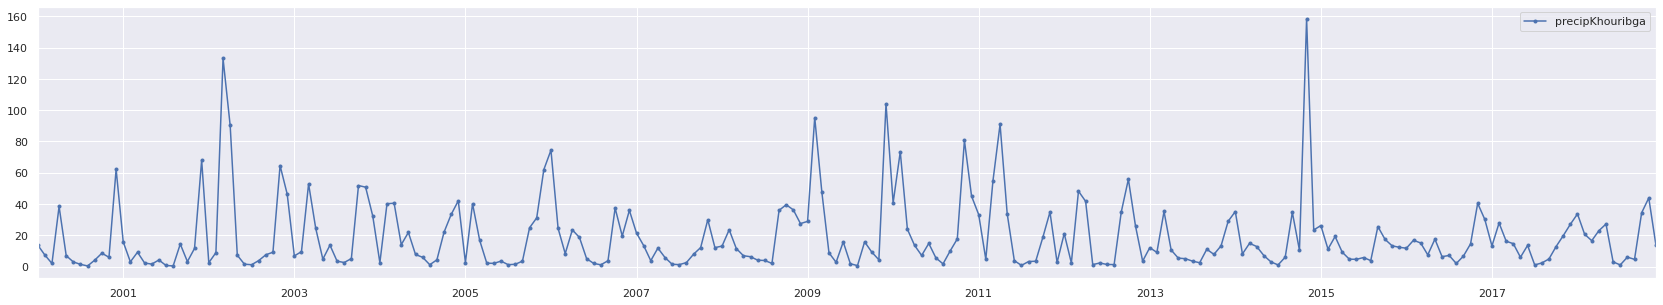

In [17]:
df_kh.plot(marker='.', figsize=(29,5));

#### Stationarity test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_kh)

if pvalue < 0.05:
    print(f"Data stationary, pvalue = {pvalue}")
else:
    print(f"Data NOT stationary, pvalue = {pvalue}")

Data stationary, pvalue = 0.004325484203942917


Creating columns containing year and month to see if there is any trends with respect to years and months.

In [20]:
df_kh['year'] = [d.year for d in df_kh.index]
df_kh['month'] = [d.strftime('%b') for d in df_kh.index]
df_kh.head()

,precipKhouribga,year,month
2000-01-01,13.872842,2000,Jan
2000-02-01,7.474373,2000,Feb
2000-03-01,2.075285,2000,Mar
2000-04-01,38.477597,2000,Apr
2000-05-01,7.025321,2000,May


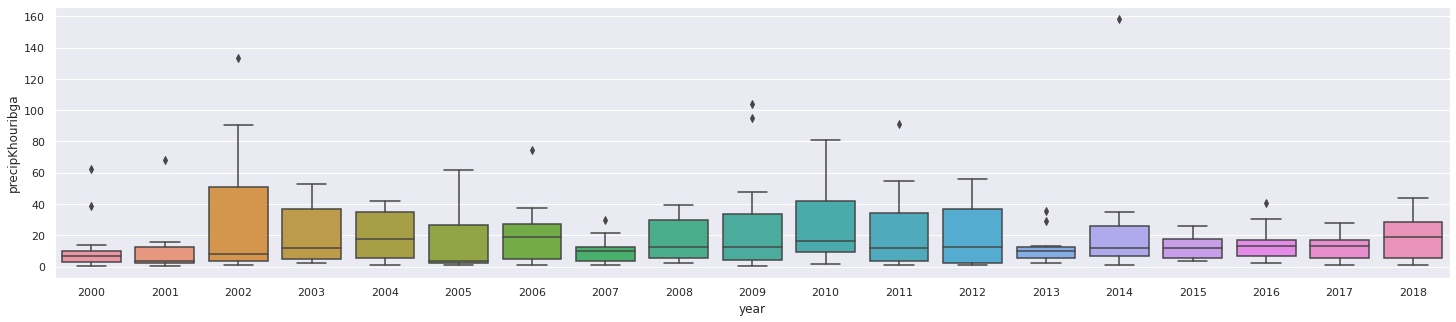

In [21]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='year', y="precipKhouribga", data=df_kh, ax=ax);

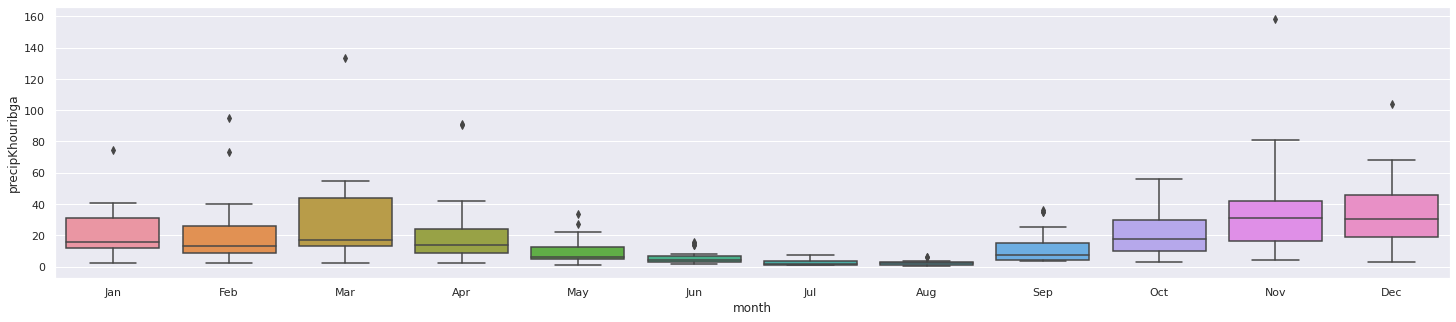

In [22]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='month', y="precipKhouribga", data=df_kh, ax=ax);

#### Extract and plot trend, seasonal and residuals

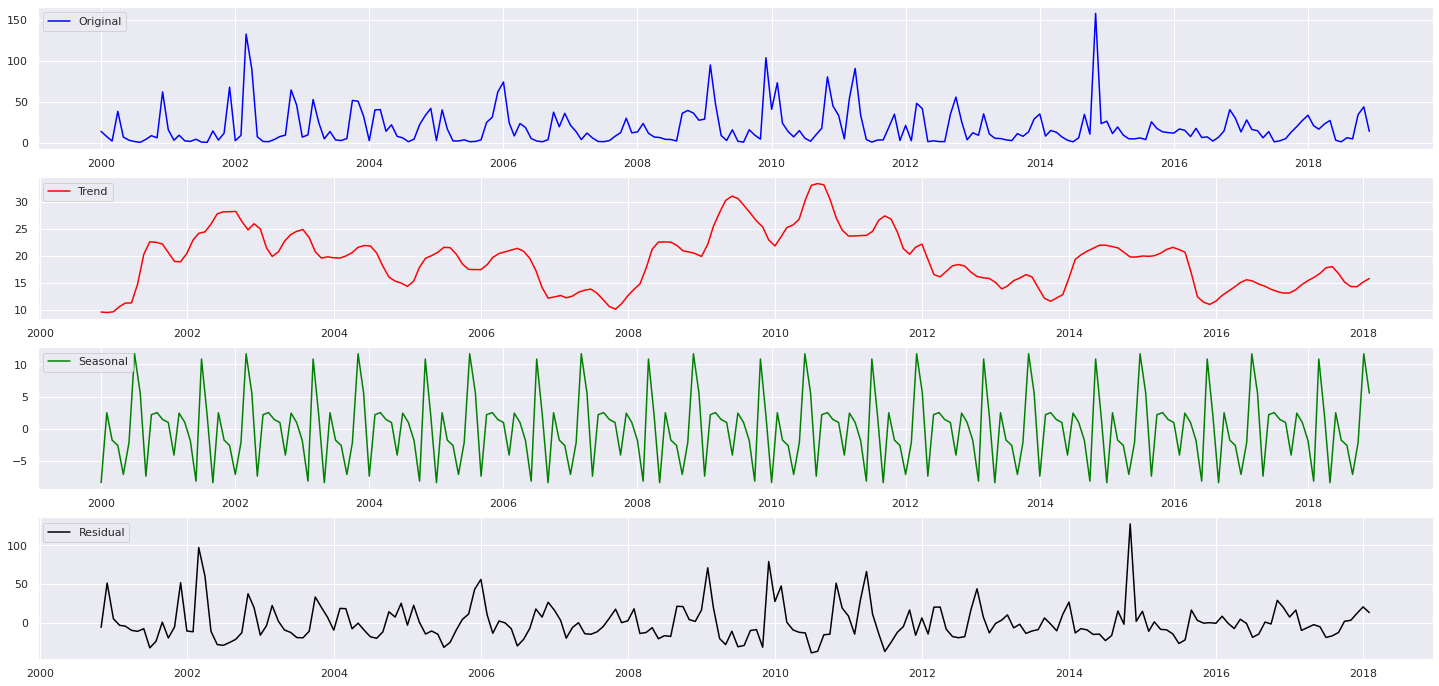

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df_kh['precipKhouribga'], model ='additive', period=20)

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(25,12))
plt.subplot(411)
plt.plot(df_kh['precipKhouribga'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

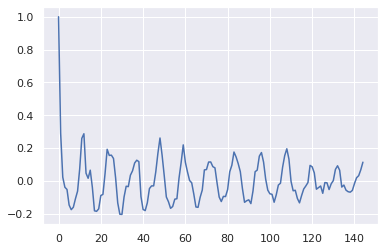

In [24]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf

acf_144 = acf(df_kh['precipKhouribga'], nlags=144)
plt.plot(acf_144);

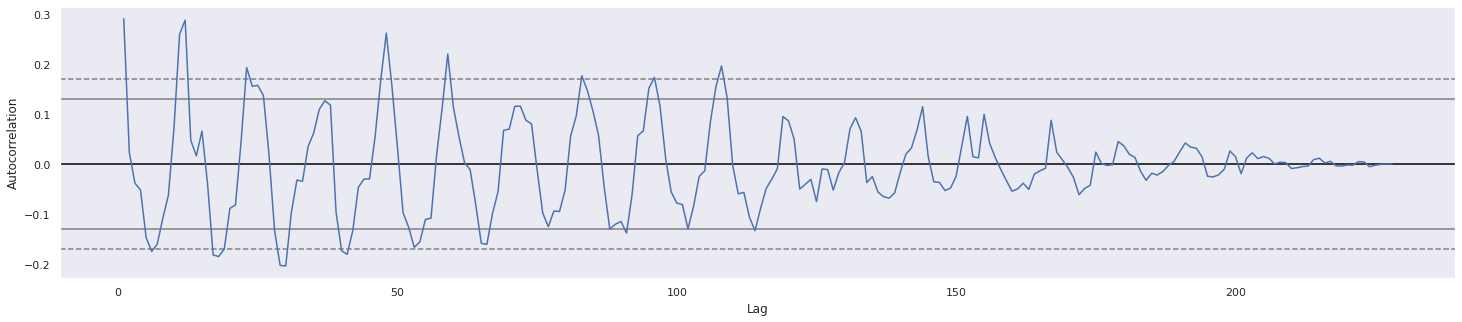

In [25]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(25, 5))
autocorrelation_plot(df_kh['precipKhouribga'],ax=ax);

## Forecasting using LSTM

In [60]:
df_kh.drop(['year', 'month'], axis=1, inplace=True)

In [62]:
len(df_kh)

228

In [63]:
train = df_kh.iloc[:200]
test = df_kh.iloc[200:]

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [65]:
df_kh.head(),df_kh.tail()

(            precipKhouribga
 2000-01-01        13.872842
 2000-02-01         7.474373
 2000-03-01         2.075285
 2000-04-01        38.477597
 2000-05-01         7.025321,
             precipKhouribga
 2018-08-01         6.111350
 2018-09-01         4.688000
 2018-10-01        34.422764
 2018-11-01        43.916373
 2018-12-01        13.955878)

In [66]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [67]:
scaled_train[:10]

array([[0.08486009],
       [0.04432583],
       [0.01012264],
       [0.24073107],
       [0.04148109],
       [0.01622572],
       [0.00644958],
       [0.        ],
       [0.02349572],
       [0.05154389]])

In [68]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [103]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [104]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08486009 0.04432583 0.01012264 0.24073107 0.04148109 0.01622572
 0.00644958 0.         0.02349572 0.05154389 0.03513471 0.3913457 ]
Predict this y: 
 [[0.09710477]]


In [105]:
X.shape

(1, 12, 1)

In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [141]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 150)               91200     
                                                                 
 dense_26 (Dense)            (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [142]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0249
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0243
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0226
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0236
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0226
Epoch 6/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0227
Epoch 7/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0218
Epoch 8/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0221
Epoch 9/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0224
Epoch 10/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0220
Epoch 11/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0215
Epoch 12/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0209
Epoch 13/100


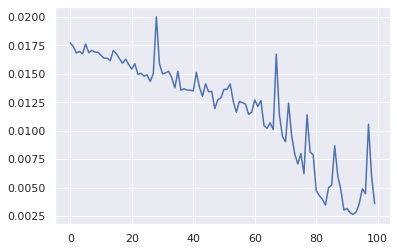

In [132]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [133]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

array([[-0.09166159]], dtype=float32)

In [134]:
scaled_test[0]

array([0.03996933])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
test_predictions

[array([-0.09166159], dtype=float32),
 array([0.19412056], dtype=float32),
 array([-0.06471661], dtype=float32),
 array([0.23339725], dtype=float32),
 array([0.3792757], dtype=float32),
 array([0.12544103], dtype=float32),
 array([0.05539133], dtype=float32),
 array([0.08243547], dtype=float32),
 array([0.12938087], dtype=float32),
 array([0.02621786], dtype=float32),
 array([-0.01212196], dtype=float32),
 array([-0.00833368], dtype=float32),
 array([-0.00537372], dtype=float32),
 array([0.07596041], dtype=float32),
 array([0.029074], dtype=float32),
 array([0.1904116], dtype=float32),
 array([0.09711286], dtype=float32),
 array([0.08437185], dtype=float32),
 array([0.0098306], dtype=float32),
 array([0.03967607], dtype=float32),
 array([0.06189548], dtype=float32),
 array([0.01514555], dtype=float32),
 array([-0.01382783], dtype=float32),
 array([-0.01416185], dtype=float32),
 array([0.02035871], dtype=float32),
 array([0.25545898], dtype=float32),
 array([0.11350067], dtype=float32),

In [ ]:
test.head()

,precipKhouribga,Predictions
2016-09-01,6.786685,14.601123
2016-10-01,14.576863,19.150308
2016-11-01,40.473986,16.197930
2016-12-01,30.176627,19.074888
2017-01-01,13.251960,20.866472


/tmp/ipykernel_63666/3081383134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:>

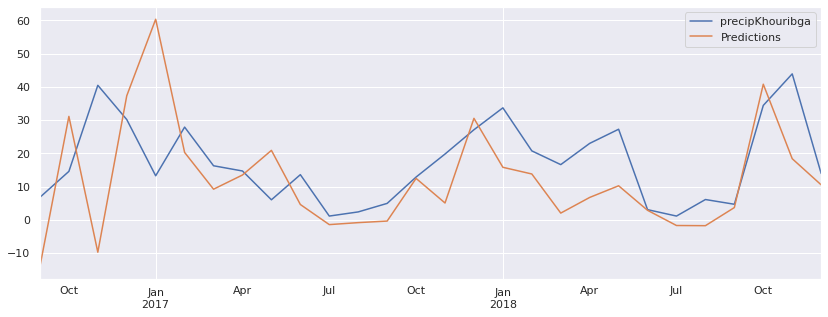

In [143]:
true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions

test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['precipKhouribga'],test['Predictions']))
print(rmse)

16.998591283693983
